## Projeto DSA: Prevendo Customer Churn em Operadoras de Telecom
#### Projeto: criar um modelo de aprendizagem de máquina que possa prever se um cliente pode ou não cancelar seu plano e qual a probabilidade de isso ocorrer.

Dados disponíveis em: https://www.kaggle.com/datasets/akshithsagar/telcom

Importando as bibliotecas necessárias:

In [1]:
import warnings
warnings.filterwarnings('ignore')

from time import time
start = time()

import pandas as pd
import numpy as np
from scipy import stats
from re import sub, match
from random import choice

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

A fonte de dados possui 2 arquivos:
- treino: dataset completo com variáveis preditoras e variável alvo (3333/5000 registros).
- teste: dataset completo com variáveis preditoras e variável alvo (1667/5000 registros).

Dicionário de dados:
- 'Unnamed: 0': ID.
- state: the US state in which the customer resides, indicated by a two-letter abbreviation.
- account_length: the number of days that this account has been active.
- area_code: the three-digit area code of the corresponding customer’s phone number.
- international_plan: whether the customer has an international calling plan: yes/no.
- voice_mail_plan: whether the customer has a voice mail feature: yes/no.
- number_vmail_messages: presumably the average number of voice mail messages per month.
- total_day_minutes: the total number of calling minutes used during the day.
- total_day_calls: the total number of calls placed during the day.
- total_day_charge: the billed cost of daytime calls.
- total_eve_minutes: the total number of calling minutes used during the evening.
- total_eve_calls: the total number of calls placed during the evening.
- total_eve_charge: the billed cost of evening time calls.
- total_night_minutes: the total number of calling minutes used during the night.
- total_night_calls: the total number of calls placed during the night.
- total_night_charge: the billed cost of nighttime calls.
- total_intl_minutes: the total number of international minutes.
- total_intl_calls: the total number of international calls.
- total_intl_charge: the billed cost for international calls.
- number_customer_service_calls: the number of calls placed to Customer Service.
- churn: whether the customer left the service: true/false.

Carregando os arquivos e realizando uma primeira visualização dos dados:

In [2]:
df_train = pd.read_csv("./treino.csv")
df_test = pd.read_csv("./teste.csv")

df_train.head(3)

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no


Variáveis categóricas:

In [3]:
cat_idx = [index for index, element in enumerate(list(df_train.dtypes)) if element == "O"]

df_train.iloc[:, cat_idx].describe()

,state,area_code,international_plan,voice_mail_plan,churn
count,3333,3333,3333,3333,3333
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,106,1655,3010,2411,2850


Variáveis numéricas:

In [4]:
num_idx = [x for x in list(range(0, len(df_train.columns.values), 1)) if x not in cat_idx]

df_train.iloc[:, num_idx].describe()

,Unnamed: 0,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3333.00000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,1667.00000,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,962.29855,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,834.00000,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,1667.00000,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,2500.00000,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,3333.00000,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Soma de valores NaN:

In [5]:
print("NA:", df_train.isna().sum(axis=0).sum())
print("Null:", df_train.isnull().sum(axis=0).sum())

NA: 0
Null: 0


**Alteração dos dados:**
- Criação de variáveis com o gasto total do cliente e o total de minutos;
- Retirada do que não é número na variável area_code;
- Transformação das variáveis international_plan e voice_mail_plan para atributos binários com 0 para não e 1 para sim;
- Transformação de state e area_code por meio de one hot encoding, remoção das variáveis originais e remoção da variável "Unnamed : 0", pois se trata do ID e não será utilizada na criação do modelo.

Caso os atributos com totais de minutos e de gastos não sejam úteis, podem ser facilmente removidos.

In [6]:
def change_df(df):
    # função definida para aplicar as mesmas alterações no dataset de teste.
    
    # 1) criando colunas com o total de minutos e o total de cobrança:
    minutes_names = [name for name in df.columns.values if "minutes" in name]
    charge_names = [name for name in df.columns.values if "charge" in name]
    
    df['total_minutes'] = df[minutes_names].sum(axis = 1)
    df['total_charge'] = df[charge_names].sum(axis = 1)
    
    # 2) transformando as variáveis para atributos binários:
    df['area_code'] = df['area_code'].apply(lambda x: sub('[^0-9]', "", x))
    
    # 3) retirando "area_code_" dos registros:
    df['international_plan'] = df['international_plan'].apply(lambda x: 1 if x == 'yes' else 0)
    df['voice_mail_plan'] = df['voice_mail_plan'].apply(lambda x: 1 if x == 'yes' else 0)
    
    # 4) Aplicando one hot encoding:
    if 'Unnamed: 0' in df.columns.values:
        df = pd.get_dummies(df.loc[:, ['state', 'area_code']]).join(
            df.drop(['Unnamed: 0', 'state', 'area_code'], axis = 1))
    else:
        df = pd.get_dummies(df.loc[:, ['state', 'area_code']]).join(
            df.drop(['state', 'area_code'], axis = 1))
    
    return df

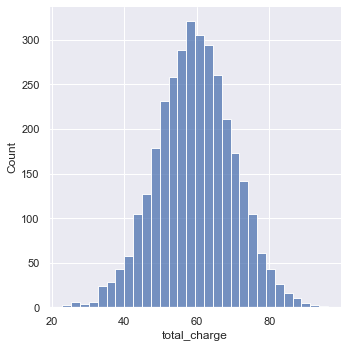

In [7]:
df_train_v2 = change_df(df_train)

sns.displot(df_train_v2, x = 'total_charge', bins = 30)

In [8]:
# Total de gasto dos 10% de clientes que mais gastam de maneira decrescente 
# até chegar ao total de gasto dos 10% de clientes que menos gastam:

for n in range(10):
    print(f'de {n*10}% a {(n+1)*10}% com maior gasto | Gasto médio:', 
          
          round(df_train_v2['total_charge'].
                sort_values(ascending=False)[
                    round(0.1*n*len(df_train_v2['total_charge'])):
                    round(0.1*(n+1)*len(df_train_v2['total_charge']))].mean(), 2), 
          
          '| Gasto total da faixa:', 
          
         round(df_train_v2['total_charge'].
                sort_values(ascending=False)[
                    round(0.1*n*len(df_train_v2['total_charge'])):
                    round(0.1*(n+1)*len(df_train_v2['total_charge']))].sum(), 2))

de 0% a 10% com maior gasto | Gasto médio: 77.81 | Gasto total da faixa: 25911.63
de 10% a 20% com maior gasto | Gasto médio: 70.47 | Gasto total da faixa: 23537.08
de 20% a 30% com maior gasto | Gasto médio: 66.45 | Gasto total da faixa: 22129.41
de 30% a 40% com maior gasto | Gasto médio: 63.46 | Gasto total da faixa: 21132.67
de 40% a 50% com maior gasto | Gasto médio: 60.79 | Gasto total da faixa: 20243.07
de 50% a 60% com maior gasto | Gasto médio: 58.13 | Gasto total da faixa: 19415.95
de 60% a 70% com maior gasto | Gasto médio: 55.54 | Gasto total da faixa: 18495.25
de 70% a 80% com maior gasto | Gasto médio: 52.36 | Gasto total da faixa: 17436.08
de 80% a 90% com maior gasto | Gasto médio: 48.64 | Gasto total da faixa: 16246.26
de 90% a 100% com maior gasto | Gasto médio: 40.84 | Gasto total da faixa: 13598.63


Apesar de os clientes que mais gastam terem uma soma que é quase o dobro da soma dos clientes que menos gastam, a distribuição se aproxima muito de uma distribuição normal e não há faixa de clientes que gaste tão acima para ser priorizada.

In [9]:
# Média de gasto dos clientes com plano internacional e/ou com plano de recado de voz:

for n in [[0, 0], [0, 1], [1, 0], [1, 1]]:
    a = df_train_v2[df_train_v2['international_plan'] == n[0]][
        df_train_v2['voice_mail_plan'] == n[1]]['total_charge'].mean()
    
    print('Média de gasto dos clientes {} international_plan e {} voice_mail_plan: {}'.format(
    'com' if n[0] == 1 else 'sem', 'com' if n[1] == 1 else 'sem', round(a, 2)))

Média de gasto dos clientes sem international_plan e sem voice_mail_plan: 59.24
Média de gasto dos clientes sem international_plan e com voice_mail_plan: 59.39
Média de gasto dos clientes com international_plan e sem voice_mail_plan: 60.82
Média de gasto dos clientes com international_plan e com voice_mail_plan: 61.46


Também não há diferença visível entre o gasto médio dos clientes com planos extras ou não.

**Avaliando correlação:**

As variáveis numéricas possuem informação de minutos conversados durante um período e o valor pago por esses minutos. Como essas variáveis provavelmente têm forte correlação, essa correlação precisa ser avaliada para verificar a necessidade de manter apenas uma das informações e evitar impactos no modelo.

<AxesSubplot:>

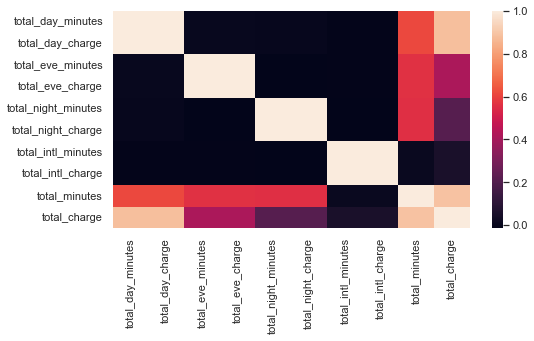

In [10]:
num_idx = [x for x in df_train_v2.columns.values if ("minutes" in x or "charge" in x)]

sns.set(rc = {'figure.figsize': (8, 4)})
sns.heatmap(df_train.loc[:, num_idx].corr())

Como era esperando, as variáveis que têm os totais de minutos ligados têm forte correlação com as variáveis que têm os totais de custo.<br>
As variáveis com totais de minutos serão removidas e, como a variável com total de custo não demonstou nenhuma informação específica, também será removida.

In [11]:
del_idx = [x for x in df_train_v2.columns.values if ("minutes" in x or "total_charge" in x)]

df_train_v2 = df_train_v2.drop(del_idx, axis = 1)

O dataset original resultou em um novo com maior número de atributos, variáveis em diferentes escalas e com uma variável alvo desbalanceada.<br>
O primeiro passo será o balanceamento:

In [12]:
ada = ADASYN()

x_resampled, y_resampled = ada.fit_resample(df_train_v2.drop('churn', axis=1), df_train_v2['churn'])

In [13]:
pd.DataFrame(y_resampled).value_counts()

churn
yes      2880
no       2850
dtype: int64

Em seguida será feita a escolha dos parâmetros para aplicar a regressão logistíca:

In [14]:
logReg_model = LogisticRegression(random_state=0)

param_grid = { 
    'C': [0.01, 0.1, 0.5, 1.0, 3.0, 5.0],
    'max_iter': [50, 100, 300, 500],
    'multi_class': ['auto', 'ovr', 'multinomial'],
}

logReg = GridSearchCV(estimator = logReg_model, param_grid = param_grid, cv= 5)
logReg.fit(x_resampled, y_resampled)

print(logReg.best_params_)

{'C': 5.0, 'max_iter': 500, 'multi_class': 'auto'}


Criando o melhor modelo:

In [15]:
logReg_model = LogisticRegression(random_state = 0, 
                                  C = 3.0, 
                                  max_iter = 500, 
                                  multi_class = 'multinomial')

logReg_model.fit(x_resampled, y_resampled)

LogisticRegression(C=3.0, max_iter=500, multi_class='multinomial',
                   random_state=0)

Alterando os dados de teste para terem o mesmo perfil dos dados de treino e fazendo as predições:

In [16]:
df_test = change_df(df_test)

df_test = df_test.drop(del_idx, axis = 1)

x_test = df_test.drop('churn', axis=1)
y_test = df_test['churn']

In [17]:
y_pred_train = logReg_model.predict(x_resampled)
y_pred = logReg_model.predict(x_test)

conf_mtx_train = confusion_matrix(y_resampled, y_pred_train)
conf_mtx_test = confusion_matrix(y_test, y_pred)

print(conf_mtx_train, "\n"*2, "Acurácia em treino:", round(accuracy_score(y_resampled, y_pred_train), 3), "\n"*2)
print(conf_mtx_test, "\n"*2, "Acurácia em teste:", round(accuracy_score(y_test, y_pred), 3))

[[2613  237]
 [ 453 2427]] 

 Acurácia em treino: 0.88 


[[1279  164]
 [ 135   89]] 

 Acurácia em teste: 0.821


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          no       0.90      0.89      0.90      1443
         yes       0.35      0.40      0.37       224

    accuracy                           0.82      1667
   macro avg       0.63      0.64      0.63      1667
weighted avg       0.83      0.82      0.83      1667



In [19]:
print('Tempo gasto até a criação do modelo:', round(time() - start, 2), 'segundos.')

Tempo gasto até a criação do modelo: 81.12 segundos.


Aplicando a uma amostra dos dados de teste já alterados para retornar o resultado esperado a partir de novos dados:

In [20]:
df = df_test.sample(n = 10).drop('churn', axis = 1)

# Fazendo as previsões:
predict = logReg_model.predict_proba(df)
    
# Retornando as probabilidades de todos clientes:
for n in range(len(predict)):
    print(f'O cliente de índice {n} apresenta {round(predict[n][1] * 100, 2)}% de chance de deixar a empresa.')

O cliente de índice 0 apresenta 43.45% de chance de deixar a empresa.
O cliente de índice 1 apresenta 14.22% de chance de deixar a empresa.
O cliente de índice 2 apresenta 83.21% de chance de deixar a empresa.
O cliente de índice 3 apresenta 56.93% de chance de deixar a empresa.
O cliente de índice 4 apresenta 16.9% de chance de deixar a empresa.
O cliente de índice 5 apresenta 46.98% de chance de deixar a empresa.
O cliente de índice 6 apresenta 12.09% de chance de deixar a empresa.
O cliente de índice 7 apresenta 17.85% de chance de deixar a empresa.
O cliente de índice 8 apresenta 0.86% de chance de deixar a empresa.
O cliente de índice 9 apresenta 74.82% de chance de deixar a empresa.


**Fim.**